In [1]:
%pip install ultralytics 
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()


In [4]:
%pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="_")#must write your own key
project = rf.workspace("connectfour").project("connect4-bmekp")
version = project.version(3)
dataset = version.download("yolov8")
display.clear_output()
#might need to modify paths in data.yaml

In [ ]:
#commented since I already trained the model
# !yolo task=segment mode=train model=yolov8n-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 #train
# !yolo task=segment mode=val model=/content/runs/segment/train2/weights/best.pt data={dataset.location}/data.yaml #validation
# !yolo task=segment mode=predict model=runs/segment/train2/weights/best.pt conf=0.7 source="Connect4-3/test/images" save = False

#another way of writing it
# model = YOLO('runs/segment/train2/weights/best.pt')  
# results = model("Connect4-3/test/images")

In [39]:
#to split the image into 42 pieces
from PIL import Image
import os

def make_squares(img):

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    img = Image.fromarray(img)
    # Create a directory to save the smaller images
    output_dir = "pieces/images4"
    os.makedirs(output_dir, exist_ok=True)

    # Define the size of each square image
    tile_width = 100
    tile_height = 100

    # Calculate the number of rows and columns
    rows = 6
    cols = 7

    # Loop through the image and save each 100x100 px square
    for row in range(rows):
        for col in range(cols):
            left = col * tile_width
            upper = row * tile_height
            right = left + tile_width
            lower = upper + tile_height
            
            # Crop the image
            cropped_img = img.crop((left, upper, right, lower))
            
            # Save the cropped image
            cropped_img.save(os.path.join(output_dir, f"tile_{row}_{col}.jpg"))

    print(f"All tiles have been saved in the '{output_dir}' directory.")



image 1/1 /home/julie/Github/ConnectFour/backend/Connect4-3/train/images/17_jpg.rf.a0170d299f40c6d1ef47cfb51cd26192.jpg: 640x640 1 board, 69.2ms
Speed: 3.8ms preprocess, 69.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
[        106         132]
[104, 134] [537, 264] [470, 526] [113, 383]
All tiles have been saved in the 'pieces/images4' directory.
the detected board
1 1 1 2 2 2 2
1 1 1 2 2 2 2
1 1 1 2 2 2 2
1 1 1 1 2 2 2
1 1 1 1 2 2 2
1 1 1 1 2 2 2


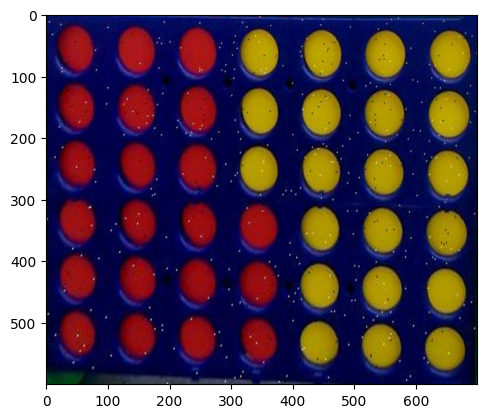

In [40]:
def Connect4BFS(matrix, start): #bfs to find closest edge of the border from the start point

    (x, y)= start
    if matrix[x][y] > 0:
        return [y, x]

    qe = [(x, y)]
    visited = set()
    visited.add((x, y))

    height = 640
    length = 640

    dx=[1, 0, -1, 0]
    dy=[0, 1, 0, -1]

    while qe:
        x, y = qe.pop(0)

        # Explore the neighboring nodes
        for k in range(4):
            nx = x+dx[k]
            ny = y+dy[k]
            if 0 <= nx < length and 0 <= ny < height:
                if (nx, ny) not in visited:
                    visited.add((nx, ny))
                    qe.append((nx, ny))
                if matrix[nx][ny] ==1:
                    return [ny, nx]
                  
                  
def Connect4GetBoard(image,matrix): #stretch image so that the border of the playable board fits in a 700x600 rectangle

    ul= Connect4BFS(matrix, (0,0)) #left up
    ur= Connect4BFS(matrix, (0,639)) #right up
    dr= Connect4BFS(matrix, (639,639)) #right down
    dl= Connect4BFS(matrix, (639,0)) #left down 
    print(ul, ur, dr, dl)
    image = cv.imread(image)
    result = image.copy()
    margin = 4
    ul[0] -= margin
    ul[1] -= margin
    ur[0] += margin
    ur[1] -= margin
    dr[0] += margin
    dr[1] += margin
    dl[0] -= margin
    dl[1] += margin
    # cv.circle(result, ul, 10, (255,0,0))
    # cv.circle(result, ur, 10, (255,0,0))
    # cv.circle(result, dr, 10, (255,0,0))
    # cv.circle(result, dl, 10, (255,0,0))
    
    src = np.array([ul, ur, dr, dl], dtype="float32")
    dst = np.array([[0, 0], [0, 700], [600, 700],[600, 0] ], dtype="float32")
    m = cv.getPerspectiveTransform(src, dst)
    result = cv.warpPerspective(image, m, (600, 700))
    result = cv.rotate(result, cv.ROTATE_90_CLOCKWISE)
    result = cv.flip(result, 1)

    return result
  

def Connect4MakeGrid(mask): #makes a matrix (640x640) of points with mask contour
  mask = mask.xy[0]
  
  print(mask[0])
  grid = np.zeros((640,640))
  for pair in mask:
    grid [int(pair[1])] [int(pair[0])] = 1

  # plt.imshow(grid)
  return grid

def DetectPiece(region):
     # Convert region to HSV for better color segmentation
    hsv = cv.cvtColor(region, cv.COLOR_BGR2HSV)
    
    # Define color ranges for red and yellow
    red_lower1 = np.array([0, 120, 70])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170, 120, 70])
    red_upper2 = np.array([180, 255, 255])
    
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    
    # Create masks for red and yellow
    mask_red1 = cv.inRange(hsv, red_lower1, red_upper1)
    mask_red2 = cv.inRange(hsv, red_lower2, red_upper2)
    mask_red = cv.bitwise_or(mask_red1, mask_red2)
    mask_yellow = cv.inRange(hsv, yellow_lower, yellow_upper)
    
    # Check for the presence of each color in the region
    red_presence = np.sum(mask_red > 0)
    yellow_presence = np.sum(mask_yellow > 0)
    
    # Determine if a piece is present and its color
    if red_presence > yellow_presence and red_presence > 1200:  # threshold for minimum presence
        return 1 #red
    elif yellow_presence > red_presence and yellow_presence > 1000:
        return 2 #yellow
    else:
        return 0 #empty

def GetState(board):
    game = np.zeros((6, 7)).astype(int)
    # we have a 700x600 image that we want to split into 100x100 squares, which we will then 
    # run some computer vision techniques to figure out the piece present
    for row in range (6):
        for col in range(7):
            region = board[row*100:(row+1)*100, col*100:(col+1)*100]
            game[row][col] = DetectPiece(region)
    print("the detected board")
    for line in game:
        print(*line)
    
    state = cv.cvtColor(board, cv.COLOR_BGR2RGB)
    plt.imshow(state)


    return game


def Connect4Run(image):
  model = YOLO(model="runs (1)/segment/train3/weights/best.pt") #load trained model, must change path
  # results = model('/content/Connect4-3/test/images') #test model and save results
  result = model(source=image,  save=False)
  if result[0].masks is None:
      print("No masks detected")
      return
  # Get masks from the results from the segmentation model
  mask = result[0].masks
  grid = Connect4MakeGrid(mask)
  board = Connect4GetBoard(image,grid)
  make_squares(board)
  game = GetState(board)
#   plt.imshow(board)
#   plt.show()

# path = "Connect4-3/test/images/20240325_135739_jpg.rf.e78cd6d37fa7ce47e0c99d5d2b63afa4.jpg"
path = "Connect4-3/train/images/17_jpg.rf.a0170d299f40c6d1ef47cfb51cd26192.jpg"
Connect4Run(path)